4423680/4422102 [==============================] - 2s 0us/step
Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 3s 47us/step - loss: 0.5307 - accuracy: 0.4470 - val_loss: 0.4602 - val_accuracy: 0.0000e+00
Epoch 2/20
60000/60000 [==============================] - 3s 46us/step - loss: 0.4295 - accuracy: 0.4871 - val_loss: 0.4051 - val_accuracy: 0.0000e+00
Epoch 3/20
60000/60000 [==============================] - 3s 47us/step - loss: 0.3990 - accuracy: 0.4907 - val_loss: 0.3856 - val_accuracy: 0.0000e+00
Epoch 4/20
60000/60000 [==============================] - 3s 47us/step - loss: 0.3828 - accuracy: 0.4937 - val_loss: 0.3691 - val_accuracy: 0.0000e+00
Epoch 5/20
60000/60000 [==============================] - 3s 46us/step - loss: 0.3691 - accuracy: 0.4963 - val_loss: 0.3556 - val_accuracy: 0.0000e+00
Epoch 6/20
60000/60000 [==============================] - 3s 47us/step - loss: 0.3587 - accuracy: 0.4981 - val_loss: 0.3454 - val_ac

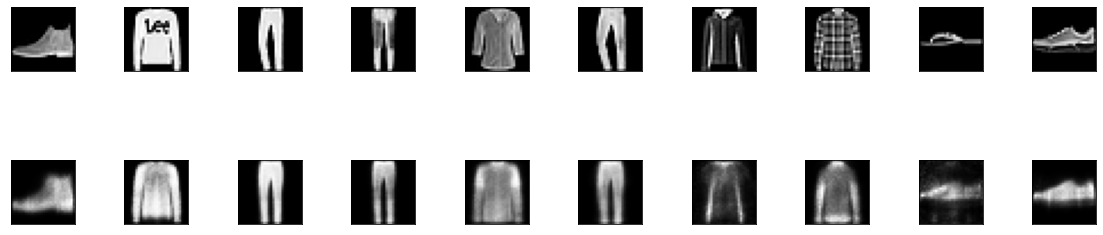

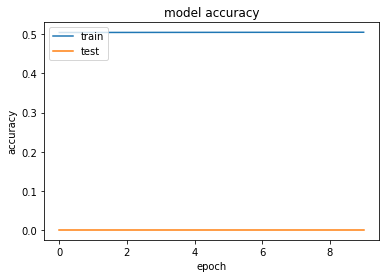

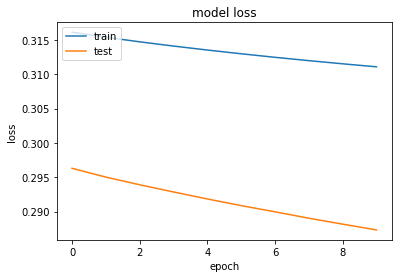

In [4]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.callbacks import TensorBoard
from time import time
from keras.datasets import fashion_mnist
import numpy as np
from keras import regularizers

# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# encoded = Dense(encoding_dim, activation='relu', activity_regularizer=regularizers.l1(1e-7))(encoded)

hidden_1 = Dense(32, activation='relu')(encoded)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])

(x_train, _), (x_test, _) = fashion_mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

#introducing noise
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

autoencoder.fit(x_train_noisy, x_train,
                epochs=20,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test_noisy, x_test_noisy))


prediction = autoencoder.predict(x_test_noisy[1].reshape(1,784))


# tensorborad = TensorBoard(log_dir="logs/{}".format(time()))
history = autoencoder.fit(x_train_noisy, x_train, batch_size=256, epochs=10, verbose=1,
                   validation_data=(x_test_noisy, x_test_noisy))

# [test_loss, test_acc] = autoencoder.evaluate(x_test, x_test)

# encode and decode some digits
# note that we take them from the test set
encoded_imgs = encoder.predict(x_test_noisy)
decoded_imgs = decoder.predict(encoded_imgs)

import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  #bonus 
    ax = plt.subplot(4, n, i + 1 + n + n)
    plt.imshow(encoded_imgs[i].reshape(16, 2))
    plt.gray()
    ax.get_xaxis().set_visible(False) 
    ax.get_yaxis().set_visible(False) 

    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + n + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

print(history)

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
